# Visualizing the results of schedulers simulation

## Define needed functions and variables

In [1]:
import matplotlib.pyplot as plt
import sys
import json
import numpy as np
import numpy.random as random
import itertools
sys.path.append('../')  # Include parent directory in module search
sys.path.append('../../')
from schedule_simulator_core.core import Distribution
from schedule_simulator_core.simulation_presets import GpuNetworkSim
from schedule_simulator_core.schedulers import FIFOScheduler, TopologicalPriorityScheduler
from schedule_simulator_core.DAGs import serialize_dag, deserialize_dag, HomogeneousLinearDAG, \
LinearDag, LayerFactory
from model_extraction.keras_model_extractor import apply_timing_profile_to_dag, keras_model_to_DAG

#### Define schedulers

In [2]:
schedulers = [FIFOScheduler(), TopologicalPriorityScheduler(preemptive=False),
              TopologicalPriorityScheduler(preemptive=True)]

#### Define custom metrics

In [3]:
def comp_to_comm_ratio(results):
    """
    The total computational units executed / total communication units executed in all of the simulation.
    This is dependent on the dag as well as the number of batches.
    It is also dependent on the rates however we are making them a constant 1 for now
    """
    return list((np.array(results["comp_units.sum"]) * np.array(results["batch_size"]))
           / np.array(results["comm_units.sum"]))

def normalize_over(results, stat_to_normalize, grouping_stat, reference_grouping_stat_value):
    
# def speedup_over_fifo(results, scheduler):
#     """
#     Total time of fifo scheduler / total time of given scheduler
#     """
#     return np.array(results["FIFOScheduler"]["time"]) / np.array(results[scheduler]["time"])

#### Visualization function

In [4]:
def line_plot_grid(results, x, y, line_variable=None, row_variable=None, title=None, save=False,
                   column_variable=None, subplot_size=None):
    group_variables = dict(r=row_variable, c=column_variable, l=line_variable)
    # Generate variable groups
    groups = dict()
    for key,value in group_variables.items():
        if value is None: # No grouping for this variable
            groups[key] = (None,)
            continue
        groups[key] = set()
        for value in results[value]:
            groups[key].add(value)
        groups[key] = list(groups[key])
        groups[key].sort()
        groups[key] = tuple(groups[key])
    # Generate all possible combinations of the above groups
    groups_combinations = list(itertools.product(*groups.values()))
    results_grouped_indices = dict()
    for combination in groups_combinations:
        results_grouped_indices[combination] = list()
    # Add each record index to its respected group
    for i in range(len(results[x])):
        group = list()
        for group_variable in group_variables.values():
            if group_variable is None:
                group.append(None)
            else:
                group.append(results[group_variable][i])
        results_grouped_indices[tuple(group)].append(i)
    # Start plotting
    if subplot_size is None:
        subplot_size = (5,5)
    figsize = subplot_size[0]*len(groups["r"]), subplot_size[1]*len(groups["c"])
    plt.figure(figsize=figsize)
    subplot_i = 1
    for column_group in groups["c"]:
        for row_group in groups["r"]:
            plt.subplot(len(groups["c"]), len(groups["r"]), subplot_i)
            sub_title = ""
            if row_group is not None:
                sub_title += "{}: {} ".format(row_variable,row_group)
            if column_group is not None:
                sub_title += "{}: {} ".format(column_variable,column_group)
            plt.title(sub_title)
            for line_group in groups["l"]:
                # We want to get all x,y data that matches the current row,column,line group
                filtered_x = [results[x][record_i] for record_i in 
                              results_grouped_indices[(row_group, column_group, line_group)]]
                filtered_y = [results[y][record_i] for record_i in 
                              results_grouped_indices[(row_group, column_group, line_group)]]
                plt.plot(filtered_x, filtered_y, marker="o", label=line_group)
            if line_group is not None:
                plt.legend()
            plt.xlabel(x)
            plt.ylabel(y)
            subplot_i += 1
    if title is not None:
        plt.suptitle(title)
    if save:
        plt.savefig("{}.png".format(title))
    plt.show()

## VGG16 simulation

Run simulation

In [5]:
# Load VGG16 Dag
with open("../../model_extraction/dags/VGG16.dag") as dag_file:
    base_dag = deserialize_dag(dag_file.read())

summary = GpuNetworkSim.run_group(gpu_rate=1,
                                      network_rate=np.arange(0.1,2.1,0.1),
                                      gpu_scheduler=FIFOScheduler(),
                                      dag=base_dag,
                                      network_scheduler=schedulers,
                                      batch_size=[1,2,4,8,16,32],
                                      n_of_batches=[2,4,16,32,64,128],
                                      resolution=1e2
                                     )

Arguments kept constant: {'gpu_scheduler', 'gpu_rate', 'dag'}
Simulation          : 1200/1200
gpu_rate            : 1
network_rate        : 2.0
gpu_scheduler       : FIFOScheduler
network_scheduler   : TopologicalPriorityScheduler:Preemptive
dag                 : {'name': 'vgg16'}
batch_size          : 16
n_of_batches        : 32


compute custom metrics

In [10]:
summary["results"]["comp_to_comm_ratio"] = comp_to_comm_ratio(summary["results"])

File IO

In [11]:
# Store simulations results to file
with open("VGG16.sims.json", "w") as file:
    json.dump(summary, file, indent=4)

In [8]:
# Load simulations results from file if it exists already.
with open("VGG16.sims.json") as file:
    summary = json.load(file)

Visualize vs comp_tomm_ratio

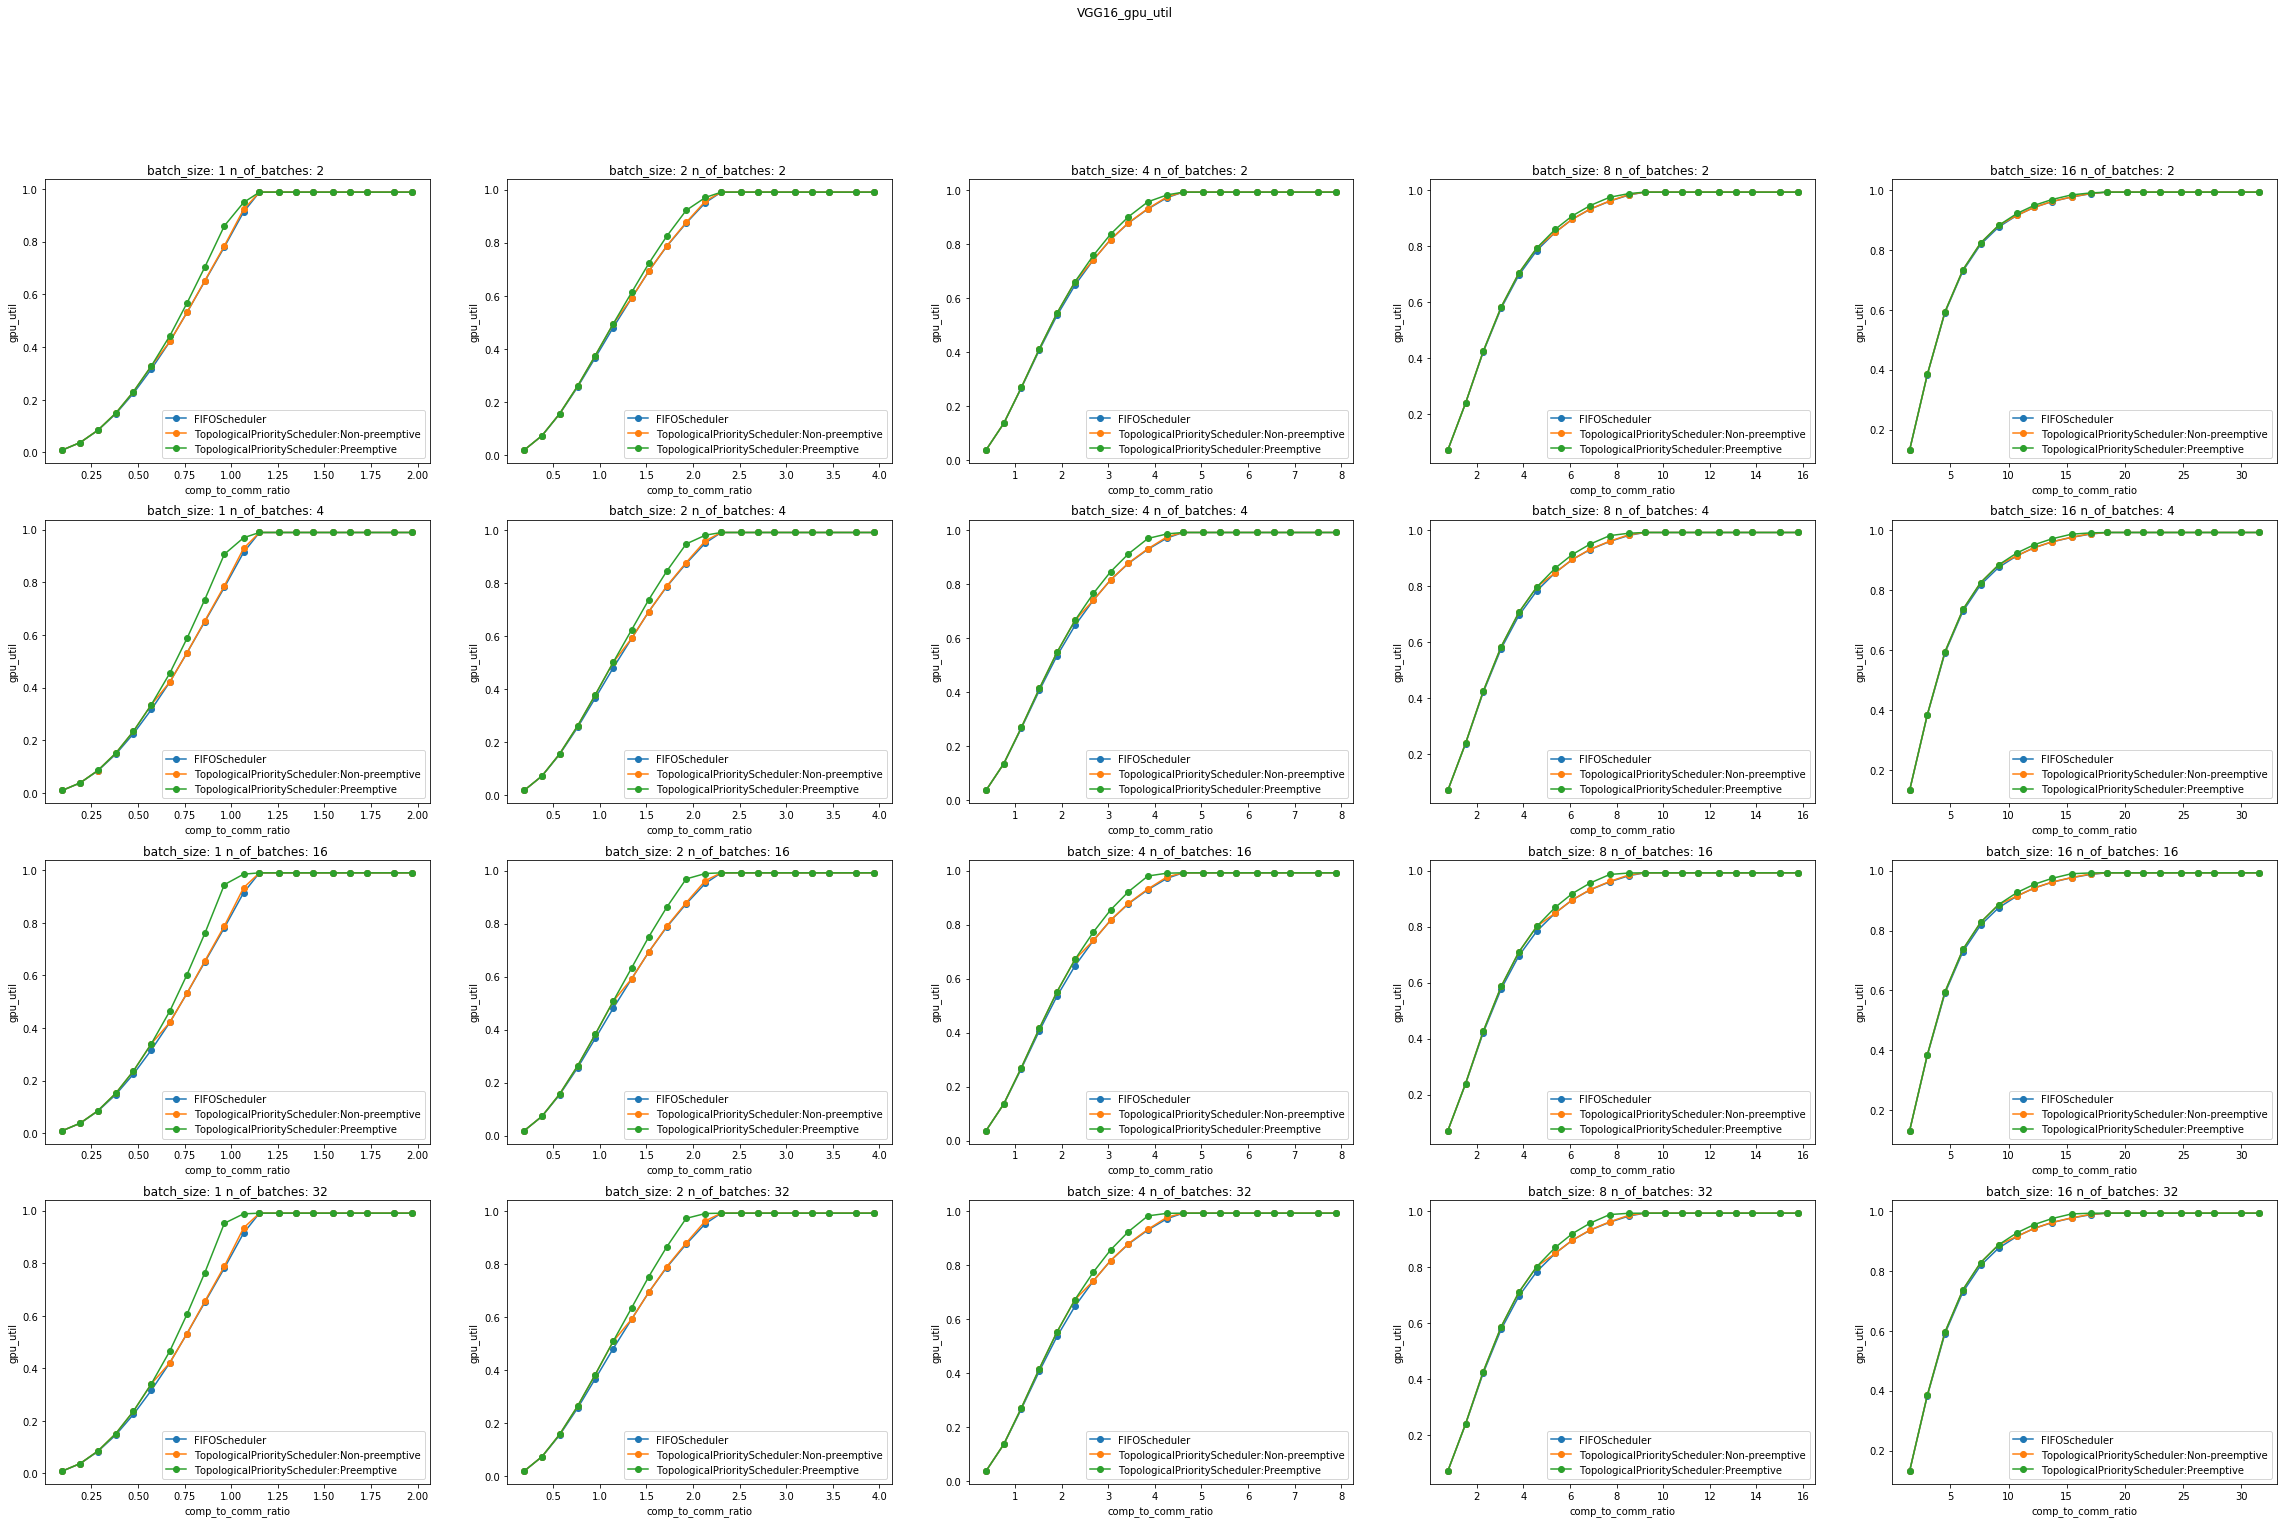

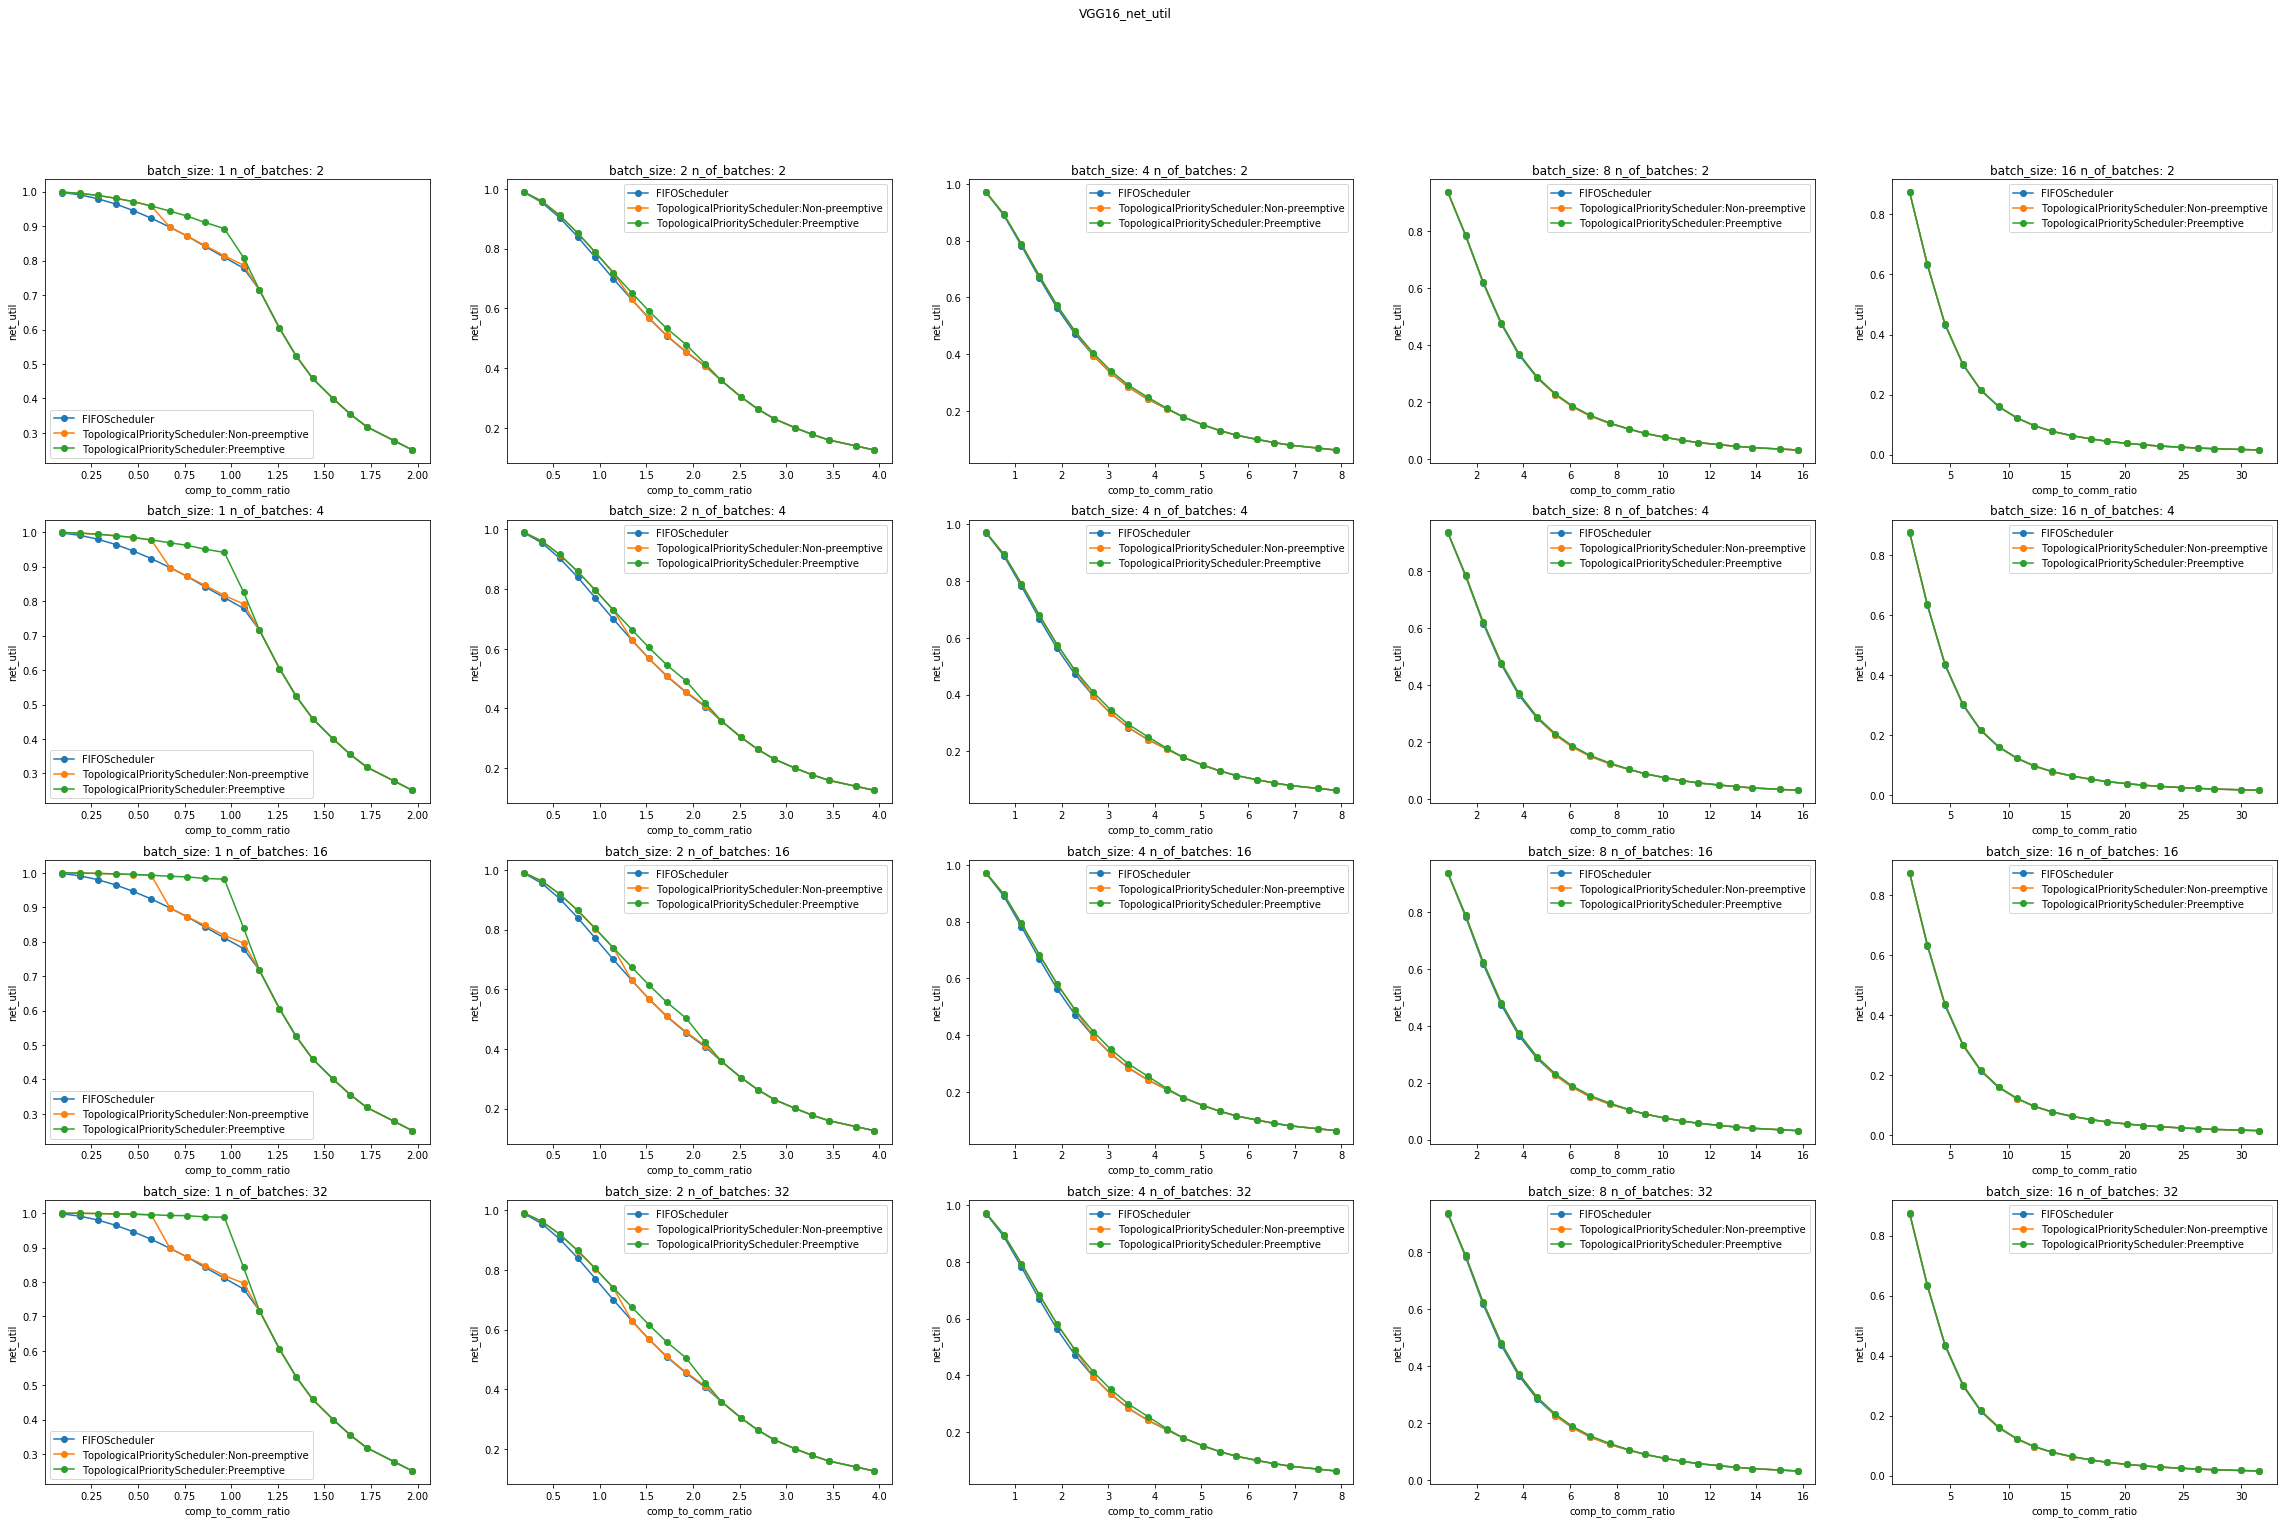

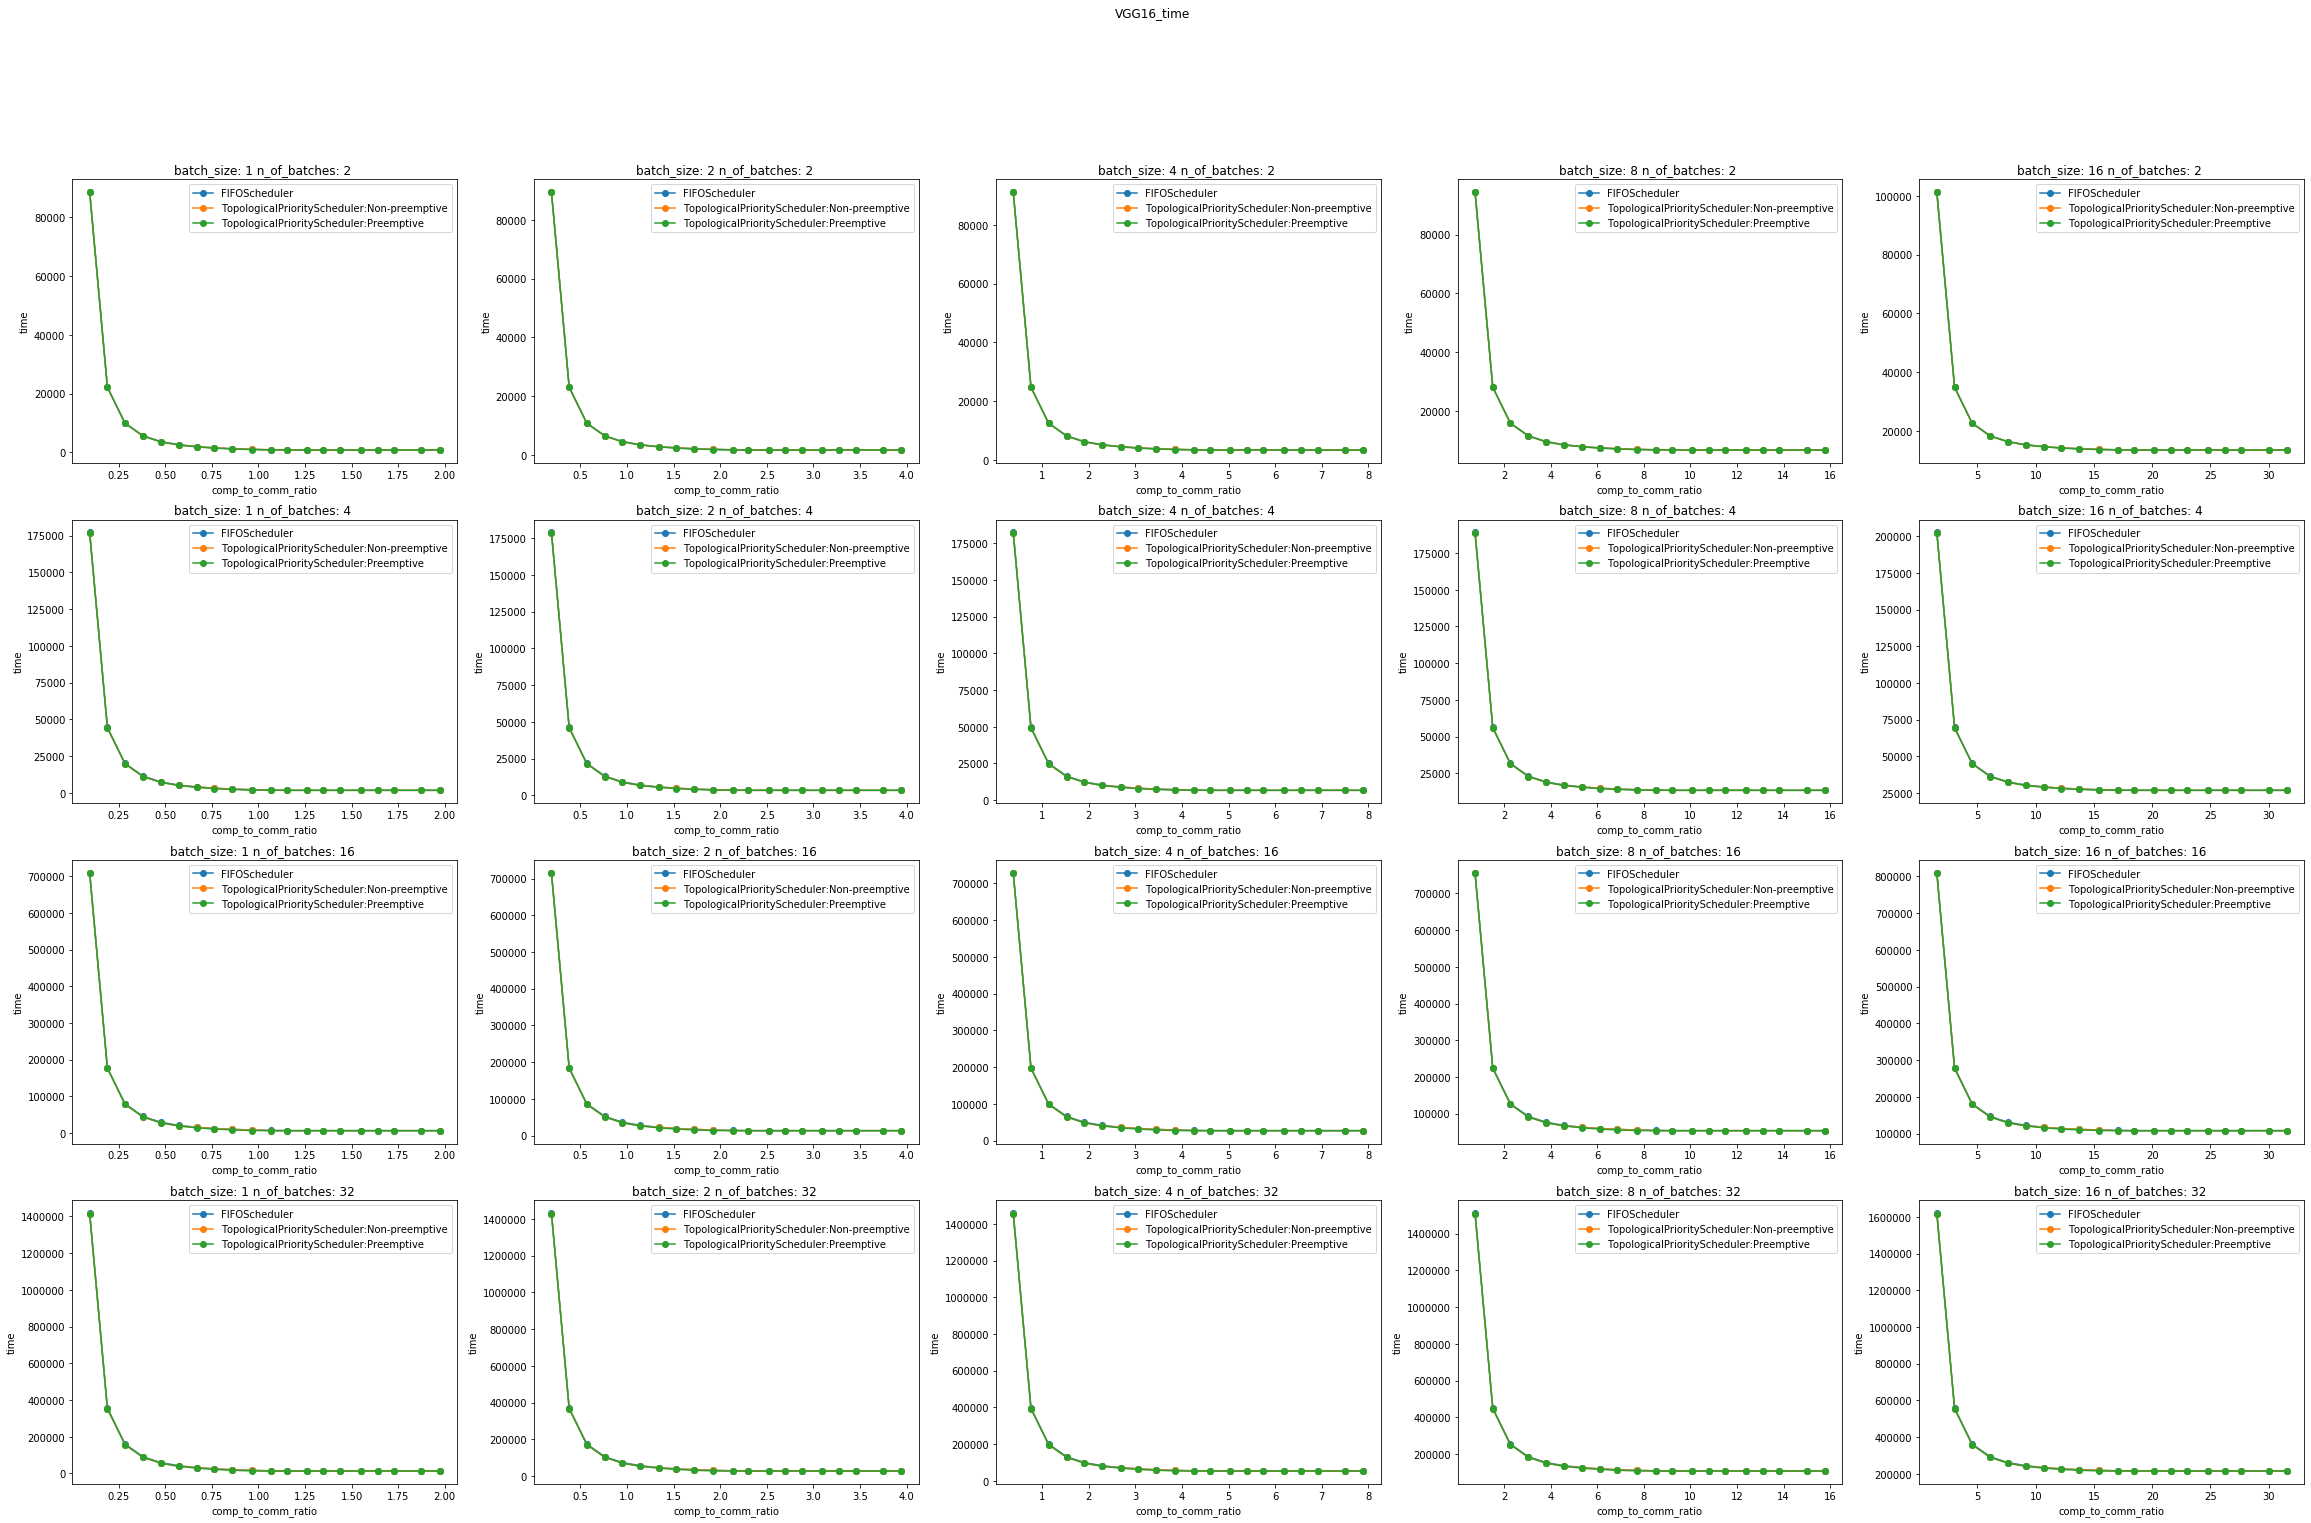

In [13]:
for y in ["gpu_util","net_util","time"]:
    line_plot_grid(summary["results"], title="VGG16_{}".format(y), save=True,
                   x="comp_to_comm_ratio",
                   y=y,
                   line_variable="network_scheduler",
                   row_variable="batch_size",
                   column_variable="n_of_batches",
                   subplot_size=(8,6)
                  )